# **News rewriting**

## **Table of contents**

* [Our goals](#Our-goals)
* [Why?](#Why?)
* [Setting up](#Setting-up)
* [Methodology](#Methodology)
* [Rewritting true news](#Rewritting-true-news)
* [Rewritting fake news](#Rewritting-fake-news)
* [Creating augmented training and testing sets](#Creating-augmented-training-and-testing-sets)
* [Heuristic test](#Heuristic-test)
* [Conclusion](#Conclusion)

In [1]:
import sys
import os
from pathlib import Path

project_root = str(Path(os.getcwd()).parent)
if project_root not in sys.path:
    sys.path.append(project_root)

from utilities import (
    plot_utilities, 
    stat_utilities,
    preprocessing_utilities,
    heuristic_utilities
)

from utilities.plot_utilities import (
    Rstyle_spines,
    multicolumn_barplot
)

from utilities.preprocessing_utilities import (
    parallel_process,
    nltk_count_word,
    clean_final_text_batch_spacy,
    get_df_from_sparse
)

from utilities.heuristic_utilities import HeuristicModel

from functools import lru_cache
import time
import subprocess
import pandas as pd
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import spacy
import textstat
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report

from IPython.core.magic import register_cell_magic
@register_cell_magic
def skip(line, cell):
    print("Cell skipped.")

tqdm.pandas()
pd.set_option('display.max_colwidth', None)
np.random.seed(42)

In [2]:
NUM_WORKERS = 20
BATCH_SIZE = 32
spacy.require_cpu()
nlp = spacy.load("en_core_web_sm")

In [3]:
@lru_cache(maxsize=128)
def rewrite_article(article_text, 
                    prompt_template: str,
                    model="mistral", 
                    timeout=60) -> str:
    """
    Rewrite an article in Reuters style using Ollama.
    
    Args:
        article_text (str): The text to rewrite
        prompt (str): The instructions sent to the model
        model (str): The model to use (default: "mistral")
        timeout (int): Maximum seconds to wait for response
        
    Returns:
        str: Rewritten article or original if error
    """
    
    prompt = prompt_template.format(article_text=article_text)

    try:
        # Run with timeout to prevent hanging
        start_time = time.time()
        
        result = subprocess.run(
            ["ollama", "run", model, prompt],
            capture_output=True,
            text=True,
            timeout=timeout
        )
        
        # Process the result
        if result.returncode == 0:
            rewritten_text = result.stdout.strip()
            #print(f"Rewriting completed in {time.time() - start_time:.2f} seconds")
            return rewritten_text
        else:
            print(f"Error: {result.stderr}")
            return article_text
            
    except subprocess.TimeoutExpired:
        print(f"Rewriting timed out after {timeout} seconds")
        return np.nan
    except Exception as e:
        print(f"Unexpected error: {str(e)}")
        return np.nan

In [4]:
reuters_like_prompt = ("Rewrite the following article in a professional Reuters news tone. "
                       "Do not add location lines or extra newlines. "
                       "Delete image or video credit that are often used in low level media." 
                       "Preserve the original message's meaning:\n\n"
                       "{article_text}")

In [5]:
social_network_prompt = ("Rewritewthe following formal news article in a casual social media style. "
                         "Use more casual language, shorter sentences, and an informal tone. "
                         "Add some typical social media elements like hashtags where appropriate. "
                         "Make it sound like something shared on Twitter or Facebook. "
                         "Use only unicode characters. Avoid using hook or attention grabber."
                         "IMPORTANT: Do not alter any facts from the original article, maintain complete factual accuracy. "
                         "Just change the style, not the substance:\n\n"
                         "{article_text}")

## **Our goals**

<div style="background-color: #f8d7dA; padding: 10px; border-radius: 5px;">
    
In this notebook, we aim to:

* Run a local Mistral LLM model using Ollama.
* Augment our training and test sets by generating rewritten news—i.e., transforming true news to mimic social media posts (a common format for fake news) and vice versa.
* Compare the rewritten news with the original to analyze differences and potential impacts on our model.
</div>

## **Why?**

<div style="background-color: #e8f4f8; padding: 10px; border-radius: 5px;">
    
The first question to answer is naturally: **Why are we rewriting the news?**
    
During our extensive EDA, we discovered that the true and fake news in our dataset follow two very distinctive patterns. On one hand, the true news articles were primarily sourced from Reuters, giving them a distinctive professional style. On the other hand, the fake news articles were largely collected from social media posts, resulting in a more informal and inconsistent tone.

This raises a critical issue: Will our model learn to detect whether a news article is true or fake, or will it simply recognize where the article was disseminated? The bias introduced during data collection makes it difficult for the model to generalize effectively.
So, why not leverage LLMs? Large language models have natural rewriting capabilities, allowing us to rewrite news articles in different styles. We can use this ability to make some true news articles resemble social media posts and some fake news articles read like professional journalism.

Of course, our goal is not to rewrite the entire dataset. Doing so would be time-consuming and wouldn’t necessarily make the dataset more realistic. Instead, we aim to rewrite a few hundred articles, carefully tracking them during training and testing to analyze how our model performs on them.
</div>

## **Setting up**

<div style="background-color: #e8f4f8; padding: 10px; border-radius: 5px;">

Running this notebook should be straightforward. You just need to ensure that **Ollama** is installed along with the **Mistral** model. I also encourage you to experiment with the rewriting process using other models.  

Since I’m running this locally, I opted for **Mistral**, as it doesn’t require a **large GPU** to run.  

### **Installing Ollama and Mistral**
#### **For Linux/macOS:**
```bash
curl -fsSL https://ollama.com/install.sh | sh
```
#### **For Windows:**  
Download Ollama from [this link](https://ollama.com/download).  

Once installed, you can pull or run the model. The first time you do this, it will **automatically download** the required files:  
```bash
ollama pull mistral
```
or  
```bash
ollama run mistral
```

Now you should be ready to use the notebook.
</div>

## **Methodology**

<div style="background-color: #e8f4f8; padding: 10px; border-radius: 5px;">

Our notebook serves as an **interface** between our dataset and **Ollama**, which runs in the background. To achieve this, we’ve written a function called **`rewrite_article`**, which takes:  
1. A **piece of text** (the original news article).  
2. A **prompt** that instructs the model on how to rewrite the text (e.g., changing its style).  

We use **two prompts**:  
* **`reuters_like_prompt`** → Rewrites the news in a professional, Reuters-style tone.  
* **`social_network_prompt`** → Rewrites the news as if it were originally collected from social media.  

If you're using a **GPU**, the rewriting time will depend on the length of the original article. However, for most news pieces, the process will take **more than 30 seconds**.  

Now, let’s look at a few examples:  
* **Rewriting a true news article** to make it sound like a social media post.  
* **Rewriting a fake news article** to make it read like a professionally written Reuters piece.  

</div>

In [6]:
train_set = pd.read_csv("../data/train_set.csv", index_col=0)
test_set = pd.read_csv("../data/test_set.csv", index_col=0)

train_true_news = train_set[train_set["label"] == 0]
train_fake_news = train_set[train_set["label"] == 1]

test_true_news = test_set[test_set["label"] == 0]
test_fake_news = test_set[test_set["label"] == 1]

In [7]:
random_true_news_idx = np.random.randint(0, train_true_news.shape[0])
random_true_news = train_true_news["text"].iloc[random_true_news_idx]
random_true_news

'The special counsel appointed to look into links between Russian officials and U.S. President Donald Trump’s 2016 campaign is conducting a criminal investigation, including whether there was any obstruction of justice, Democratic Senator Richard Blumenthal said on Thursday. Former FBI Director Robert Mueller, who was named on Wednesday as a special counsel to lead the probe, is conducting an investigation “of criminal allegations that are extremely serious, including possible obstruction of justice,” Blumenthal told reporters after senators met Deputy Attorney General Rod Rosenstein. Probe by U.S. special counsel is a criminal investigation: Blumenthal'

In [8]:
rewrite_article(random_true_news, social_network_prompt)

'🔥🚨 Breaking: Mueller\'s probe ain\'t no joke, y\'all! 🚨🔥\n\nIt\'s official, peeps - the guy tapped as special counsel to dig into Trump\'s crew & the Russians is running a criminal investigation. Word on the street is he\'s looking into obstruction of justice, too.\n\nGot the scoop from Sen. Blumenthal himself. He said Mueller\'s investigation involves "extremely serious" allegations, like possible obstruction of justice 💥🙅\u200d♂️.\n\nThey met with Deputy AG Rod Rosenstein after the powwow. Now we wait and see what shakes out. Stay tuned! #TrumpRussiaProbe #MuellerInvestigation 🕵️\u200d♀️🔎💥\n\n(Source: Reuters)'

In [9]:
random_fake_news_idx = np.random.randint(0, train_fake_news.shape[0])
random_fake_news = train_fake_news["text"].iloc[random_fake_news_idx]
random_fake_news

'So it begins the suing of Americans who don t agree with Obama s dangerous decree that allows men to use the little girl s room at will. Will the first little girl who is raped in the Target bathroom receive the same media attention and compassion as this MAN will get from leftist LGBT agitators and progressive pigs of America? D.C. police have charged a security guard at a Giant grocery store with simple assault after a transgender woman said the guard forced her out of the women s restroom. Ebony Belcher, 32, said she went to the Giant in northeast D.C. with a friend to pick up a delivery from the Western Union.While at the Giant, she asked a store employee to point her to the restroom and passed a female security officer standing in the hallway. The officer came into the restroom and told her to get out, according to Belcher. Via: NBCWashingtonAlmost as disturbing as the transvestite who is eagerly using the little girls room (even though his genitals clearly show he is a male and 

In [10]:
rewrite_article(random_fake_news, reuters_like_prompt)

"A security guard at a Washington D.C. Giant grocery store has been charged with simple assault after a transgender woman reportedly was asked to leave the women's restroom. Ebony Belcher, 32, alleged that a female security officer ordered her out of the restroom.\n\nThe incident has sparked debate over bathroom usage and gender identity. Critics argue that allowing individuals to use restrooms according to their self-identified gender could potentially endanger women and girls. They question whether the media and progressive advocates will show the same compassion toward a victim of sexual assault in a public restroom as they do towards transgender individuals.\n\nRick Wells, a commentator, expressed confusion over what he perceives as a voluntary brainwashing or mind control exercise regarding gender identity. He questioned why pronouns are being redefined and argued that clothes do not determine one's gender.\n\nThe reporting on the incident has been criticized for mischaracterizing

<div style="background-color: #e8f4f8; padding: 10px; border-radius: 5px;">
    
As we can see from the texts above, our news articles have been **rewritten as expected**.  

When we transformed a **Reuters-style article** into a **social media-style post**, we noticed several key changes:  
- The addition of **emojis** and **attention-grabbing hooks**.  
- A **more informal vocabulary** and conversational tone.  

Similarly, when we rewrote a **fake news article** to match **Reuters' professional style**, we observed:  
- A **completely different syntax**, making the text more structured.  
- A **more nuanced and subtle tone**, improving credibility.  

These transformations demonstrate how effectively the model adapts text to different styles.

</div>

## **Rewritting true news**

<div style="background-color: #e8f4f8; padding: 10px; border-radius: 5px;">
We will start by rewriting true news from the training and test sets into a more social media-like style. We will augment our training dataset with 400 rewritten true news articles and our test set with 100.

Additionally, we have set a 60-second timeout for the rewriting process. If it exceeds this limit, the function will return `np.nan`. We will later identify and remove these cases.
</div>

In [11]:
%%skip
some_train_true_news = train_true_news.copy().sample(2000)
some_train_true_news["rewritten_text"] = (some_train_true_news["text"]
                                    .progress_apply(lambda text: rewrite_article(text, 
                                                                        social_network_prompt, 
                                                                        "mistral", 
                                                                        timeout=60)))
some_train_true_news.dropna(inplace=True)
some_train_true_news.to_csv("../data/some_train_true_news.csv")

Cell skipped.


In [12]:
some_train_true_news = pd.read_csv("../data/some_train_true_news.csv", index_col=0)
some_train_true_news.head(2)

,text,label,rewritten_text
20989,"Somali authorities have handed over to Ethiopia a senior official of the ONLF rebel group, which is fighting for the secession of Ogaden from Ethiopia, the group said. Abdikarin Sheikh Muse, an executive committee member who lived in the Somali capital Mogadishu, was detained by security in Galkayo in Somalia s semi-autonomous Galmudug state on August 23, the ONLF said in a statement. Quoting sources close to the Somali cabinet, it said the Somali government had forcefully handed over Abdikarin Sheikh Muse to Ethiopia without his consent in violation of U.N. convention relating to the status of refugees. Ethiopian officials were not available for comment. The Ogaden National Liberation Front (ONLF) launched its bid for secession of the Somali Region, also known as Ogaden, in eastern Ethiopia in 1984. In 2007, Ethiopian forces waged a large-scale offensive against them after the group attacked a Chinese-run oil facility, killing 74 people. Analysts say the rebels have since been severely weakened but are still able to launch hit-and-run attacks. The region they operate may contain 4 trillion cubic feet of gas and major oil deposits, mining experts say. China s GCL-Poly Petroleum Investments signed a production sharing deal with the government in late 2013 to develop two gas fields. Somalia hands over ONLF rebel leader to Ethiopia: group",0,"🚨📣 BREAKING NEWS! 📣🚨\n\nSomali gov't, allegedly in a no-consent move, 👀 handover ONLF exec, Abdikarin Sheikh Muse, to Ethiopean authorities! 😮\n\nThe Ogaden National Liberation Front (ONLF) spills the tea: they nabbed him in Galkayo, Mogadishu on Aug 23. 📅\n\nSomali cabinet insiders claim this violation of UN refugee convention. 🤦‍♀️ Ethiopean officials unavailable for comment. 🤷‍♂️\n\nThe ONLF, fighting for Ogaden's secession since 1984, has reportedly been weakened but still strikes back. 💥🏃‍♂️\n\nGas and oil deposits in their turf? Potentially 4 trillion cubic feet of gas and major oil reserves! 🌬️💰\n\nChina's GCL-Poly Petroleum Investments signed a deal with the Ethiopian gov't in late 2013 to develop these fields. 🇨🇳🤝🇪🇹 #ONLF #Ethiopia #Somalia #GasAndOilDeposits #RefugeeIssues"
13816,"Police in northern Japan have found eight men near a boat at a seaside marina who said they were from North Korea, and appear to be fishermen whose vessel ran into trouble, rather than defectors, a police official said on Friday. The incident comes at a time of rising tension over North Korea s nuclear arms and missile programs after President Donald Trump redesignated the isolated nation a state sponsor of terrorism, allowing the United States to levy further sanctions. Japanese police took the men into custody after a resident of Yurihonjo, a city in the prefecture of Akita, told police of the presence of individuals of unknown nationality, the official, Yoshinobu Ito, told Reuters. The men, who said they were North Koreans, appear to be fishermen whose wooden boat, found nearby, had trouble and went adrift, Ito said. Police and authorities were now dealing with the matter, he added. Chief Cabinet Secretary Yoshihide Suga, asked if the possibility the men were spies had been ruled out, told a news conference authorities were handling the matter carefully. Japan is studying plans to cope with a possible influx of tens of thousands of North Korean evacuees should a military or other crisis break out on the peninsula, as well as how to weed out spies and terrorists among them, a domestic newspaper said. Last week, the Japan Coast Guard rescued three North Korean men on a capsized boat in the Sea of Japan, off central Japan. The men said they were fishermen and were later sent home aboard a North Korean vessel. Twelve more crew went missing. Last week a North Korean soldier dramatically defected to the South after being shot and wounded by his country s military as he made his getaway across the border in the heavily guarded Demilitarized Zone between the two countries. Men

In [13]:
%%skip
some_test_true_news = test_true_news.copy().sample(100)
some_test_true_news["rewritten_text"] = (some_test_true_news["text"]
                                    .progress_apply(lambda text: rewrite_article(text, 
                                                                                 social_network_prompt, 
                                                                                 "mistral", 
                                                                                 timeout=60)))
some_test_true_news.dropna(inplace=True)
some_test_true_news.to_csv("../data/some_test_true_news.csv")

Cell skipped.


In [14]:
some_test_true_news = pd.read_csv("../data/some_test_true_news.csv", index_col=0)

<div style="background-color: #e8f4f8; padding: 10px; border-radius: 5px;">
Now that we have generated some "new" true news, let's analyze how they differ from the original ones using key metrics:

* Number of characters
* Number of words
* Readability score (using the Dale-Chall formula)
These metrics will help us quantify the stylistic differences introduced during the rewriting process.
</div>

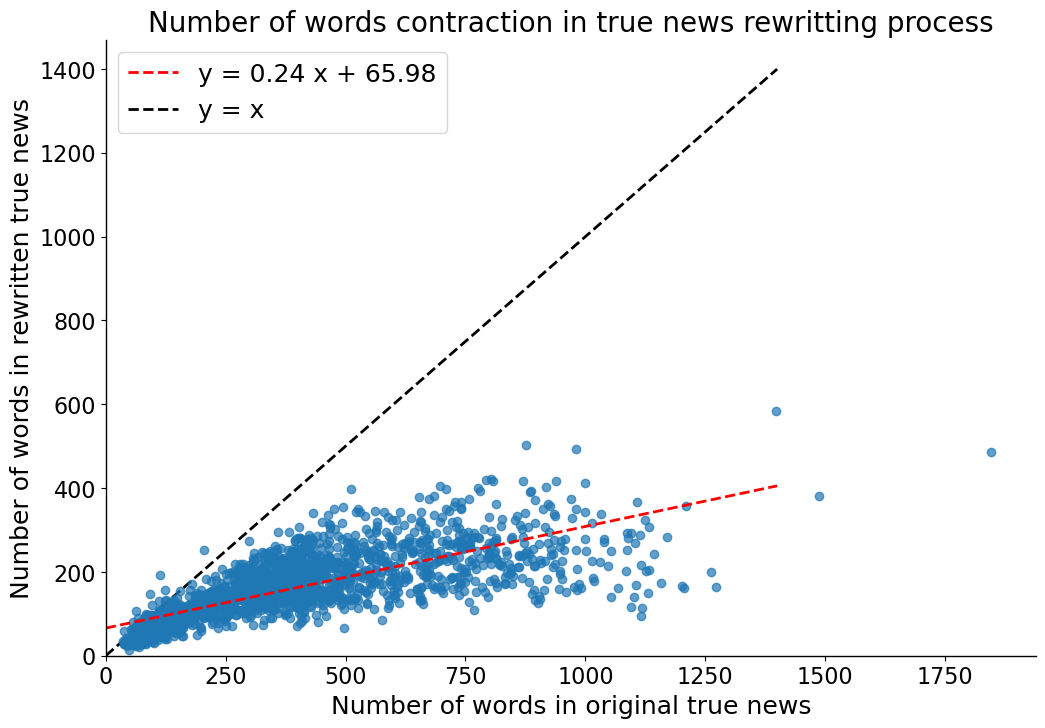

In [15]:
news_words_count = some_train_true_news["text"].apply(nltk_count_word)
rewritten_news_words_count = some_train_true_news["rewritten_text"].apply(nltk_count_word)

b, a = np.polyfit(news_words_count, rewritten_news_words_count, deg=1)

fig, ax = plt.subplots(figsize=(12, 8))
ax.scatter(news_words_count, rewritten_news_words_count, color="C0", alpha=0.7)
xseq = np.linspace(0, 1400, num=100)
ax.plot(xseq, a + b * xseq, color="r", lw=2, ls='--', label=f"y = {b:.2f} x + {a:.2f}")
ax.plot(xseq, xseq, color="k", lw=2, zorder=0, ls='--', label="y = x")

Rstyle_spines(ax, lw=1)
ax.set_xlim(left=0)
ax.set_ylim(bottom=0)
ax.set_xlabel("Number of words in original true news", fontsize=18)
ax.set_ylabel("Number of words in rewritten true news", fontsize=18)
ax.tick_params(axis='both', labelsize=16)
ax.set_title("Number of words contraction in true news rewritting process", fontsize=20)
ax.legend(fontsize=18)

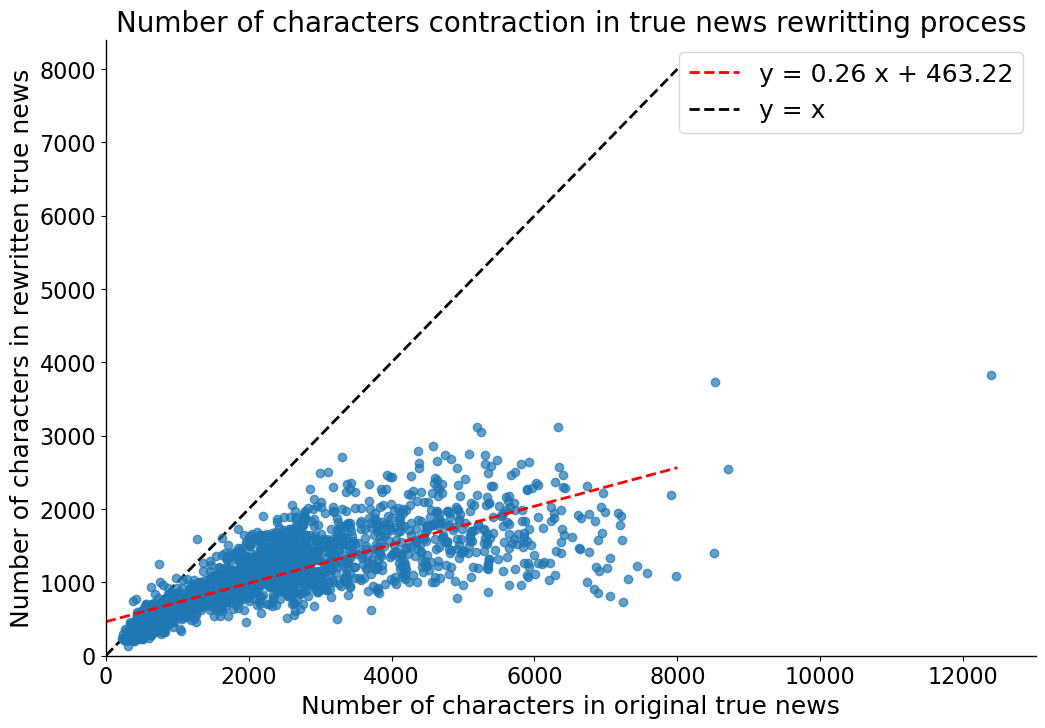

In [16]:
news_characters_count = some_train_true_news["text"].str.len()
rewritten_news_characters_count = some_train_true_news["rewritten_text"].str.len()

b, a = np.polyfit(news_characters_count, rewritten_news_characters_count, deg=1)

fig, ax = plt.subplots(figsize=(12, 8))
ax.scatter(news_characters_count, rewritten_news_characters_count, color="C0", alpha=0.7)
xseq = np.linspace(0, 8000, num=100)
ax.plot(xseq, a + b * xseq, color="r", lw=2, ls='--', label=f"y = {b:.2f} x + {a:.2f}")
ax.plot(xseq, xseq, color="k", lw=2, zorder=0, ls='--', label="y = x")

Rstyle_spines(ax, lw=1)
ax.set_xlim(left=0)
ax.set_ylim(bottom=0)
ax.set_xlabel("Number of characters in original true news", fontsize=18)
ax.set_ylabel("Number of characters in rewritten true news", fontsize=18)
ax.tick_params(axis='both', labelsize=16)
ax.set_title("Number of characters contraction in true news rewritting process", fontsize=20)
ax.legend(fontsize=18)

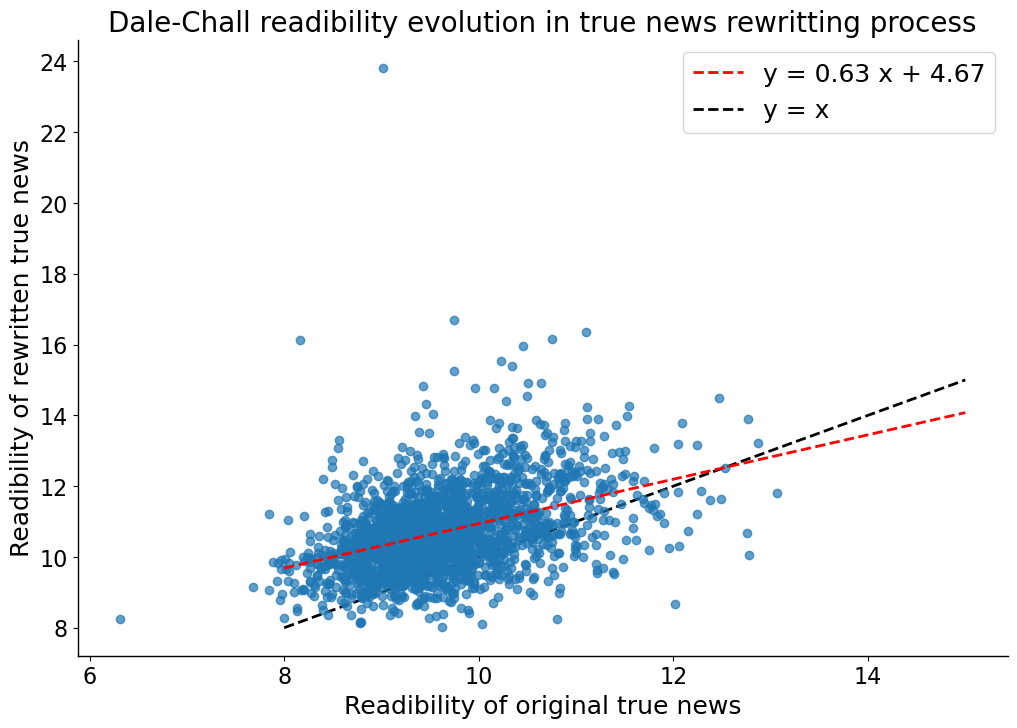

In [17]:
news_readibility = some_train_true_news["text"].apply(textstat.dale_chall_readability_score)
rewritten_news_readibility = some_train_true_news["rewritten_text"].apply(textstat.dale_chall_readability_score)

b, a = np.polyfit(news_readibility, rewritten_news_readibility, deg=1)

fig, ax = plt.subplots(figsize=(12, 8))
ax.scatter(news_readibility, rewritten_news_readibility, color="C0", alpha=0.7)
xseq = np.linspace(8, 15, num=10)
ax.plot(xseq, a + b * xseq, color="r", lw=2, ls='--', label=f"y = {b:.2f} x + {a:.2f}")
ax.plot(xseq, xseq, color="k", lw=2, zorder=0, ls='--', label="y = x")

Rstyle_spines(ax, lw=1)
ax.set_xlabel("Readibility of original true news", fontsize=18)
ax.set_ylabel("Readibility of rewritten true news", fontsize=18)
ax.tick_params(axis='both', labelsize=16)
ax.set_title("Dale-Chall readibility evolution in true news rewritting process", fontsize=20)
ax.legend(fontsize=18)

<div style="background-color: #e8f4f8; padding: 10px; border-radius: 5px;">
    
From the three graphs above, we can observe that the rewriting process has almost systematically reduced the number of words (and characters) while increasing the readability score. This suggests that, according to the Dale-Chall readability formula, the rewritten news articles are more difficult to understand than the originals.

Before drawing any conclusions, let's now examine how the process of transforming fake news into a more professional style affects these metrics.
</div>

## **Rewritting fake news**

In [18]:
%%skip
some_train_fake_news = train_fake_news.copy().sample(2000)
some_train_fake_news["rewritten_text"] = (some_train_fake_news["text"]
                                    .progress_apply(lambda text: rewrite_article(text, 
                                                                        reuters_like_prompt, 
                                                                        "mistral", 
                                                                        timeout=60)))
some_train_fake_news.dropna(inplace=True)
some_train_fake_news.to_csv("../data/some_train_fake_news.csv")

Cell skipped.


In [19]:
some_train_fake_news = pd.read_csv("../data/some_train_fake_news.csv", index_col=0)
some_train_fake_news.head(2)

,text,label,rewritten_text
34816,"The astounding hypocrisy of the leftist media has been left unchecked for decades. All of that is about to change. And no matter what side of the aisle you find yourself on, forcing the media to do their jobs and report the news is a benefit to every single American. It s not their job to be popular amongst their peers or to have opinions their readers agree with. Their job is to report the news. Perhaps this little video or nugget of truth slipped their minds?Despite mounting criticism for Donald Trump s failure to disavow former Ku Klux Klan grand wizard David Duke s support, Democratic front-runner Hillary Clinton once heaped praise for late Klan leader Sen. Robert Byrd.In a video uploaded to the State Department s official YouTube page on June 28, 2010, Clinton commemorated late Sen. Byrd by saying, Today our country has lost a true American original, my friend and mentor Robert C. Byrd. Via: Daily CallerAnd when the former KKK member, Senator Robert Byrd died, Barack Obama gave the eulogy:President Obama lauded the late Sen. Robert C. Byrd today for keeping faith with his family, his state of West Virginia and his beloved U.S. Constitution. He was a Senate icon, he was a party leader, he was an elder statesman, and he was my friend, Obama told thousands who gathered for Byrd s funeral on the steps of the golden-domed West Virginia statehouse. That s how I ll remember him. OOPS! Did The Media Think Voters Would Forget About HILLARY’S “FRIEND and MENTOR” Late KKK Leader Robert Byrd? [VIDEO]",1,"In a significant shift, the long-standing hypocrisy in leftist media reporting is set to face scrutiny. This development is advantageous for all Americans, irrespective of political affiliations, as it underscores the need for media adherence to their primary role: impartial news dissemination.\n\nDespite mounting criticism directed at Donald Trump for his failure to disavow former Ku Klux Klan Grand Wizard David Duke's support, a similar incident involving Democratic frontrunner Hillary Clinton has been overlooked. In a video uploaded on the State Department's official YouTube page on June 28, 2010, Clinton eulogized late Senator Robert Byrd, describing him as ""a true American original, my friend and mentor.""\n\nSimilarly, former President Barack Obama delivered the eulogy for Sen. Byrd, praising him as a devoted family man, a statesman of West Virginia, and a guardian of the U.S. Constitution. The funeral service was held on the steps of the golden-domed West Virginia statehouse.\n\nThe question arises: Has the media forgotten this past association with a former KKK member? [Video Link]\n\nThis incident raises questions about the impartiality and integrity of media reporting, underscoring the need for accountability and objectivity in journalism."
32465,"Former English Defence League leader Tommy Robinson went to town on a reporter today after he was interrupted in the midst of a Rebel Media interview at the scene of the London terror attack.Robinson was speaking with Rebel Media s Caolan Robertson on the unsurprising nature of the incident in light of the suspected perpetrator s identity being released. This isn t a shock to me, said Robinson. I don t understand people who are surprised by this. We have over 3,000 Muslims who are monitored 24 hours a day 7 days a week at a cost of nine billion [pounds] a year. We re following them, waiting for them to do this. As Robinson continued to rant, a crowd apparently formed around him and began filming. Among them was a reporter who quickly took the offense against Robinson. Do you have information that no one else seems to have? inquired the reporter. I have information that shows there was four terrorist attacks last week in France, shot back Robinson. There was 12 planned last year. Driving your car like this man has done is exactly what the Inspire magazine, which is Al Qaeda s magazine, which was downloaded by 50,000 British Muslims last year 50,00

In [20]:
%%skip
some_test_fake_news = test_fake_news.copy().sample(100)
some_test_fake_news["rewritten_text"] = (some_test_fake_news["text"]
                                    .progress_apply(lambda text: rewrite_article(text, 
                                                                        reuters_like_prompt, 
                                                                        "mistral", 
                                                                        timeout=60)))
some_test_fake_news.dropna(inplace=True)
some_test_fake_news.to_csv("../data/some_test_fake_news.csv")

Cell skipped.


In [21]:
some_test_fake_news = pd.read_csv("../data/some_test_fake_news.csv", index_col=0)

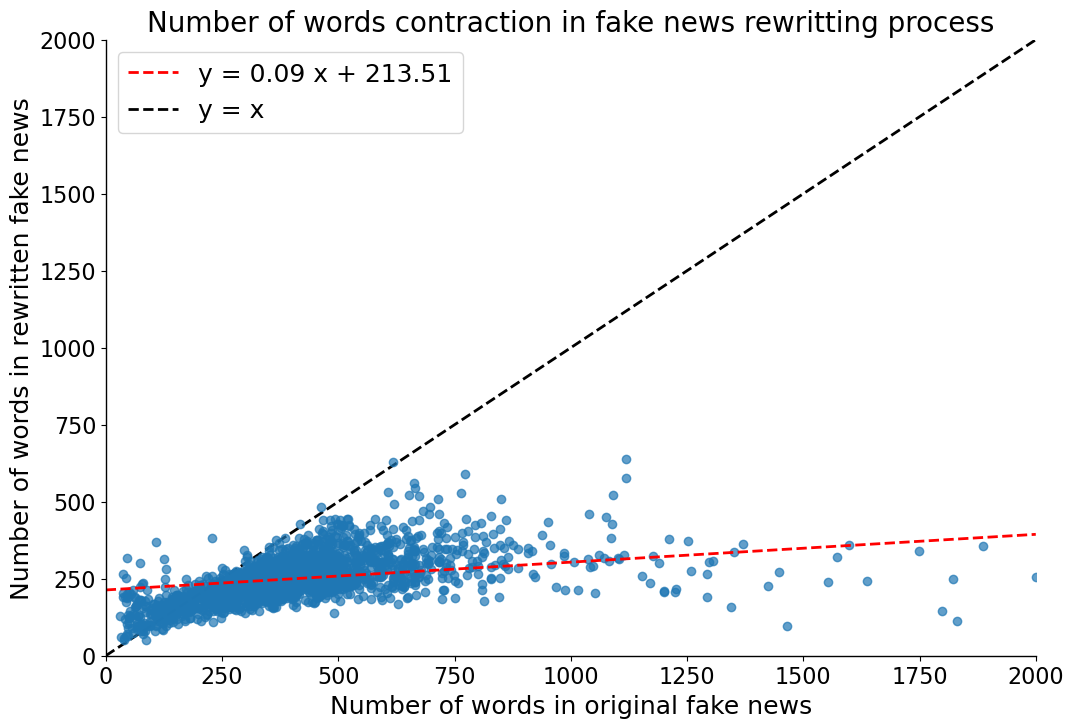

In [22]:
news_words_count = some_train_fake_news["text"].apply(nltk_count_word)
rewritten_news_words_count = some_train_fake_news["rewritten_text"].apply(nltk_count_word)

b, a = np.polyfit(news_words_count, rewritten_news_words_count, deg=1)

fig, ax = plt.subplots(figsize=(12, 8))
ax.scatter(news_words_count, rewritten_news_words_count, color="C0", alpha=0.7)
xseq = np.linspace(0, 2000, num=100)
ax.plot(xseq, a + b * xseq, color="r", lw=2, ls='--', label=f"y = {b:.2f} x + {a:.2f}")
ax.plot(xseq, xseq, color="k", lw=2, zorder=0, ls='--', label="y = x")

Rstyle_spines(ax, lw=1)
ax.set_xlim((0, 2000))
ax.set_ylim((0, 2000))
ax.set_xlabel("Number of words in original fake news", fontsize=18)
ax.set_ylabel("Number of words in rewritten fake news", fontsize=18)
ax.tick_params(axis='both', labelsize=16)
ax.set_title("Number of words contraction in fake news rewritting process", fontsize=20)
ax.legend(fontsize=18)

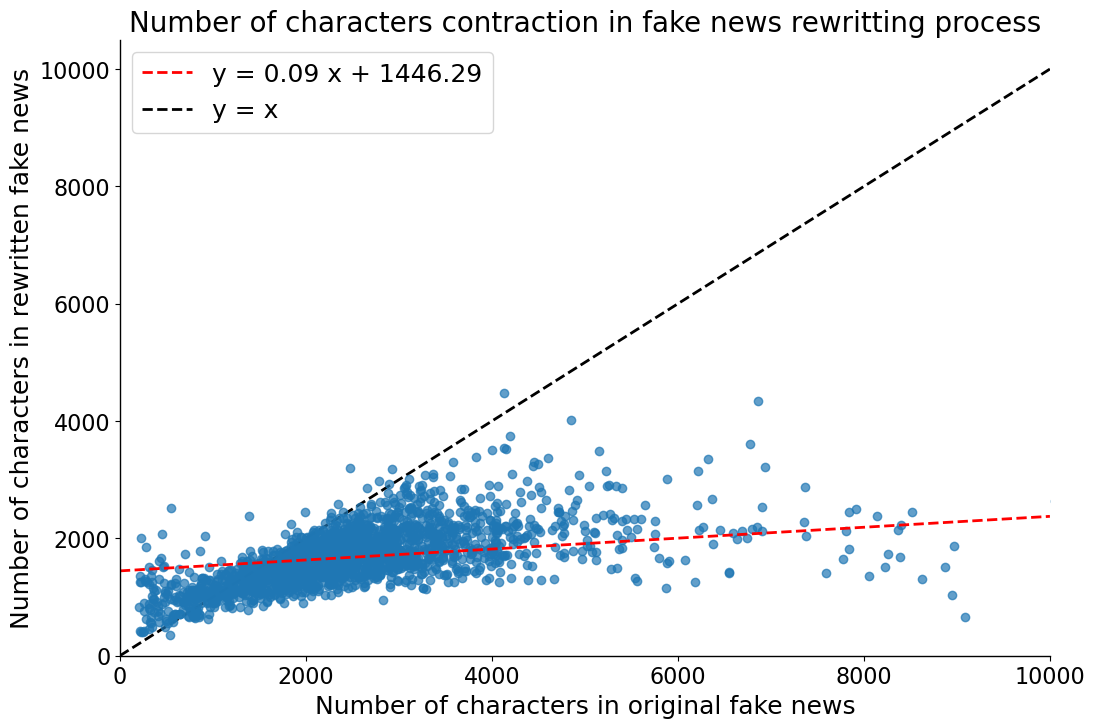

In [23]:
news_characters_count = some_train_fake_news["text"].str.len()
rewritten_news_characters_count = some_train_fake_news["rewritten_text"].str.len()

b, a = np.polyfit(news_characters_count, rewritten_news_characters_count, deg=1)

fig, ax = plt.subplots(figsize=(12, 8))
ax.scatter(news_characters_count, rewritten_news_characters_count, color="C0", alpha=0.7)
xseq = np.linspace(0, 10000, num=100)
ax.plot(xseq, a + b * xseq, color="r", lw=2, ls='--', label=f"y = {b:.2f} x + {a:.2f}")
ax.plot(xseq, xseq, color="k", lw=2, zorder=0, ls='--', label="y = x")

Rstyle_spines(ax, lw=1)
ax.set_ylim(bottom=0)
ax.set_xlim((0, 10000))
ax.set_xlabel("Number of characters in original fake news", fontsize=18)
ax.set_ylabel("Number of characters in rewritten fake news", fontsize=18)
ax.tick_params(axis='both', labelsize=16)
ax.set_title("Number of characters contraction in fake news rewritting process", fontsize=20)
ax.legend(fontsize=18)

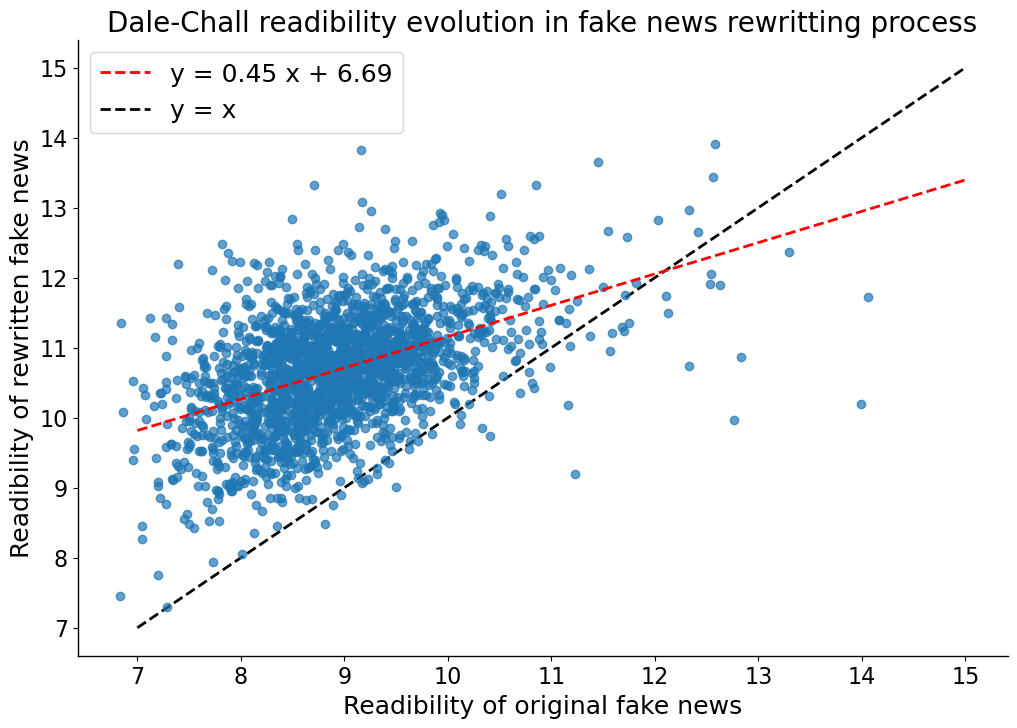

In [24]:
news_readibility = some_train_fake_news["text"].apply(textstat.dale_chall_readability_score)
rewritten_news_readibility = some_train_fake_news["rewritten_text"].apply(textstat.dale_chall_readability_score)

b, a = np.polyfit(news_readibility, rewritten_news_readibility, deg=1)

fig, ax = plt.subplots(figsize=(12, 8))
ax.scatter(news_readibility, rewritten_news_readibility, color="C0", alpha=0.7)
xseq = np.linspace(7, 15, num=10)
ax.plot(xseq, a + b * xseq, color="r", lw=2, ls='--', label=f"y = {b:.2f} x + {a:.2f}")
ax.plot(xseq, xseq, color="k", lw=2, zorder=0, ls='--', label="y = x")

Rstyle_spines(ax, lw=1)
ax.set_xlabel("Readibility of original fake news", fontsize=18)
ax.set_ylabel("Readibility of rewritten fake news", fontsize=18)
ax.tick_params(axis='both', labelsize=16)
ax.set_title("Dale-Chall readibility evolution in fake news rewritting process", fontsize=20)
ax.legend(fontsize=18)

<div style="background-color: #e8f4f8; padding: 10px; border-radius: 5px;">
    
Once again, the same pattern emerged as with the true news: the rewriting process tends to systematically reduce the number of words (and characters) while also making the text more difficult to read. This is a reason to be cautious with these extra synthetic articles. Every model we train will be evaluated on both the non-augmented and augmented datasets, and their results on the test set will be compared.

Nonetheless, the process is interesting. A better approach would have been to use a multi-agent environment, where different agents contribute to the rewriting process. One could collect ideas, another—inspired by other articles from our dataset—would write a draft, and a third would control the quality. This could be implemented using the `crewai` framework. Some attempts were made in that direction, but it would require more computational power.
</div>

## **Creating augmented training and testing sets**

In [25]:
some_train_fake_news = some_train_fake_news.rename(columns={"text": "drop", "rewritten_text": "text"}).drop(["drop"], axis=1)
some_train_true_news = some_train_true_news.rename(columns={"text": "drop", "rewritten_text": "text"}).drop(["drop"], axis=1)

In [26]:
augmented_train_set = pd.concat([train_set, some_train_fake_news, some_train_true_news]).reset_index().drop(["index"], axis=1)
augmented_test_set = pd.concat([test_set, some_test_fake_news, some_test_true_news]).reset_index().drop(["index"], axis=1)
augmented_train_set.head(2)

,text,label
0,"British police made a new arrest on Monday in their investigation into a bomb attack on a London underground train earlier this month. The man, 20, was detained at a house in the Welsh capital Cardiff by counter-terrorism officers, London police said. He is the seventh man to have been arrested over the attack at Parsons Green station in London on Sept. 15 which injured 30 people. It was Britain s fifth major militant attack so far this year. Last Friday, teenager Ahmed Hassan appeared in court charged with attempting to murder passengers on board the train heading to central London from the southwest suburb of Wimbledon and causing an explosion likely to endanger life using the highly volatile triacetone triperoxide (TATP) - known as the mother of Satan - or another explosive substance. The 18-year-old, from Sunbury-on-Thames, a town to the southwest of London, was remanded in custody until Oct. 13. The home-made bomb engulfed a carriage in flames, but apparently failed to fully explode. Two other men are still being questioned by police while three others have since been released by detectives and face no further action. Searches are still ongoing at one address in Surrey, south of London, and in Cardiff. British police arrest seventh man over bomb attack on London train",0
1,"U.S. Homeland Security Secretary John Kelly said on Sunday that in applying the provisions of President Donald Trump’s executive order on refugees and immigration, he deemed the entry of lawful permanent residents “in the national interest.” Trump defended his move to ban entry of refugees and people from seven Muslim-majority nations and said on Sunday the United States would resume issuing visas for all countries in the next 90 days as he faced rising criticism at home and abroad and new protests in U.S. cities. U.S. homeland security head: Entry of lawful permanent residents in 'national interest'",0


## **Heuristic test**

In [27]:
words_to_remove = ["image", "say", "said", "via", "video", "reuters", "like", "featured", "capture",
                   "watch", "getty", "even", "actually", "really", "screenshot", "screen", 
                   "trump", "go", "get", "don", "know", "thing", "think", "tweet", "tweeter", 
                   "facebook", "youtube", "happen", "seek", "let", "tweet", "trade", "mr",
                   "minister", "fact", "government", "official", "claim", "come", "hillary"
                   "didn", "ve", "spokesman", "s", "t", "word", "american", "americans", "didn"]

cleaned_train_set = parallel_process(augmented_train_set, 
                                     clean_final_text_batch_spacy, 
                                     num_workers=NUM_WORKERS, 
                                     nlp=nlp, 
                                     batch_size=BATCH_SIZE,
                                     words_to_remove=words_to_remove)

/home/czank/miniconda3/envs/dl_capstone/lib/python3.12/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
100%|███████████████████████████████████████████| 20/20 [03:41<00:00, 11.08s/it]


In [28]:
tfidf_cleaned = TfidfVectorizer(
    strip_accents='unicode',
    max_features=400,
    lowercase=False,
    ngram_range=(1, 1)
)

tfidf_cleaned_train_matrix = tfidf_cleaned.fit_transform(cleaned_train_set["text"])
tfidf_cleaned_test_matrix = tfidf_cleaned.transform(test_set["text"])

tfidf_cleaned_train_df = get_df_from_sparse(tfidf_cleaned_train_matrix,
                                    cleaned_train_set,
                                    "label",
                                    tfidf_cleaned.get_feature_names_out(), 
                                    )

tfidf_cleaned_test_df = get_df_from_sparse(tfidf_cleaned_test_matrix, 
                                    test_set,
                                    "label",
                                    tfidf_cleaned.get_feature_names_out(),
                                    )

In [29]:
tfidf_model_cleaned = HeuristicModel()
tfidf_model_cleaned.setup_model(tfidf_cleaned_train_df, "label", bins=20)

Text(0.5, 0.98, 'Text features Information Value')

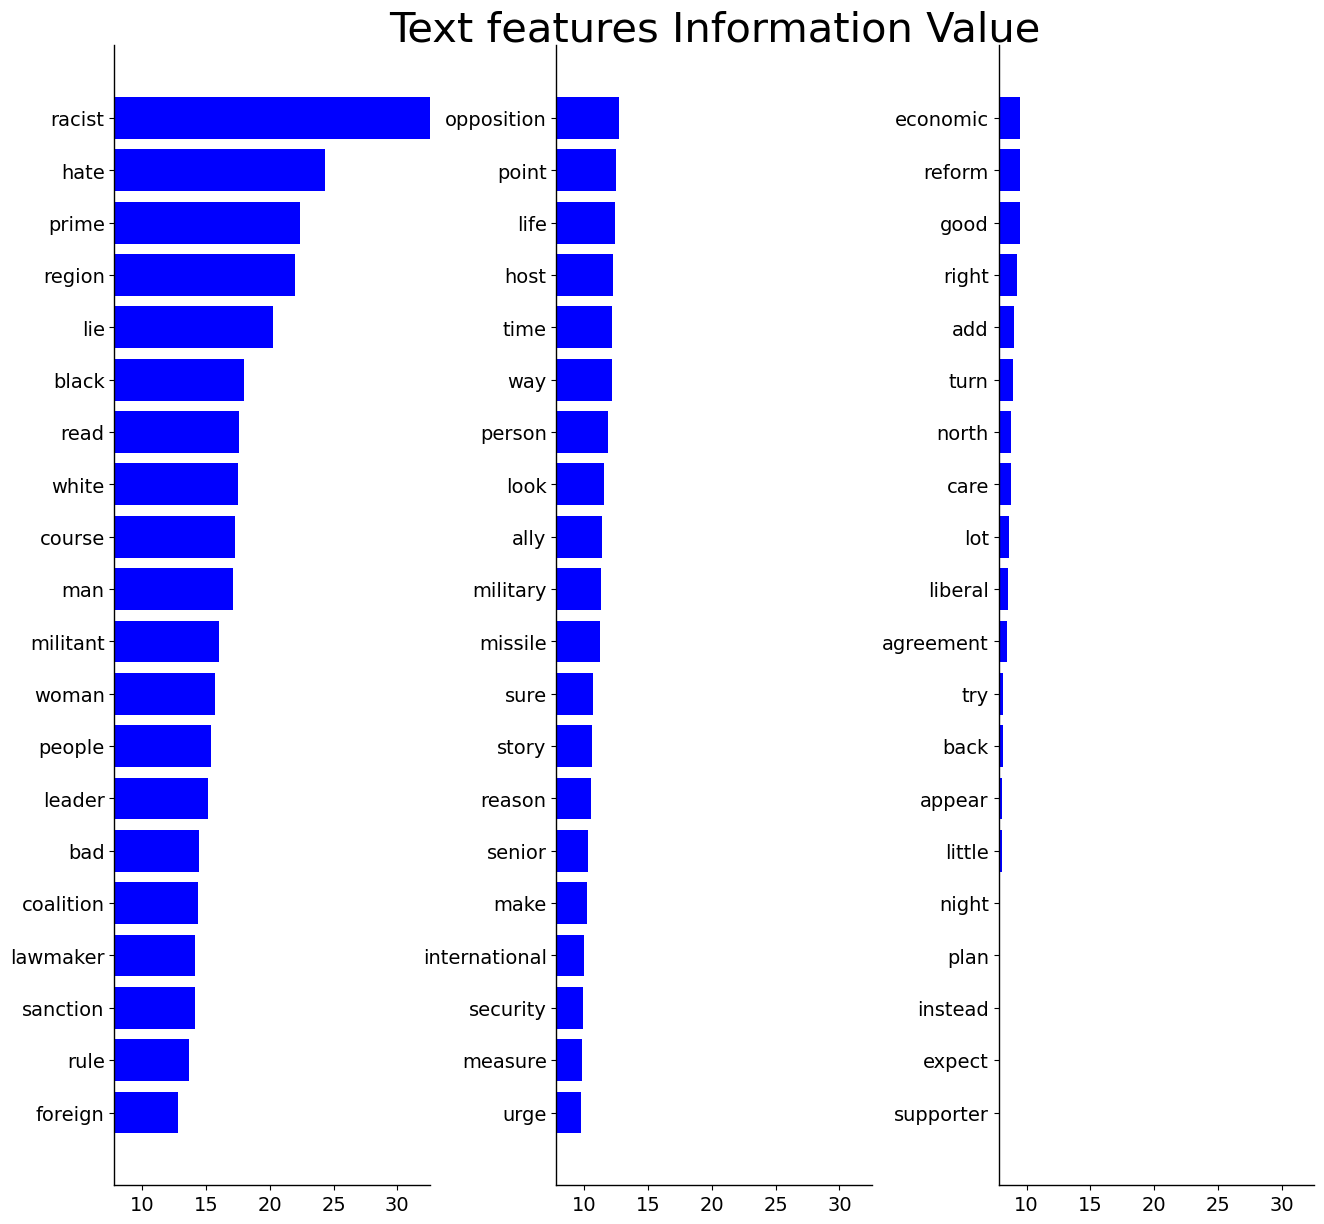

In [30]:
IV_scores_tfidf_cleaned = tfidf_model_cleaned.get_IV_scores()
IV_tfidf_cleaned = pd.DataFrame(list(IV_scores_tfidf_cleaned.items()), columns=['Feature', 'IV'])
fig = plt.figure(figsize=(12, 12))
axs = multicolumn_barplot(
    IV_tfidf_cleaned[:60], fig, y="Feature", width="IV", tick_fs=14, num_col=3
)
fig.suptitle("Text features Information Value", fontsize=30)

In [31]:
tfidf_cleaned_scores = tfidf_model_cleaned.predict(tfidf_cleaned_test_df, n_jobs=-1)
print(classification_report(tfidf_cleaned_test_df["label"], tfidf_cleaned_scores))

Features used for predictions are 
['move', 'appear', 'comment', 'position', 'islamic', 'individual', 'important', 'nation', 'investigation', 'urge', 'presidential', 'worker', 'nominee', 'market', 'team', 'describe', 'strong', 'justice', 'terrorist', 'block', 'confirm', 'criminal', 'deny', 'request', 'charge', 'process', 'face', 'right', 'talk', 'show', 'young', 'voter', 'warn', 'legislation', 'pay', 'low', 'tell', 'late', 'mean', 'anti', 'control', 'senator', 'new', 'change', 'decide', 'share', 'able', 'region', 'make', 'world', 'grow', 'party', 'social', 'feel', 'decision', 'break', 'chief', 'race', 'potential', 'bring', 'stay', 'chairman', 'serve', 'deal', 'percent', 'adviser', 'large', 'respond', 'believe', 'information', 'future', 'power', 'law', 'community', 'speak', 'history', 'representative', 'care', 'racist', 'good', 'remain', 'win', 'organization', 'crime', 'email', 'job', 'rally', 'action', 'idea', 'way', 'express', 'supporter', 'lose', 'man', 'hour', 'bill', 'hear', 'vote'

<div style="background-color: #e8f4f8; padding: 10px; border-radius: 5px;">
If we compare it with the heuristic model score, we see no change. However, this does not mean it will not help our model generalize better. We will conclude the usefulness of this process after training our ML and DL models.
</div>

## **Conclusion**

<div style="background-color: #f8d7dA; padding: 10px; border-radius: 5px;">
    
In this notebook, we've:

* Rewritten both fake and true news from the training and test sets using the Mistral LLM via the Ollama API. The goal was to make fake news appear more professional and true news resemble social media posts.
* Observed that during this rewriting process, articles tend to become shorter and more difficult to read, raising concerns about the viability of this method.
* Proposed an improvement by using a multi-agent framework such as CrewAI to enhance the rewriting process.
* Created two new datasets: an augmented training set and an augmented test set. While the usefulness of the augmented test set remains uncertain, it will be interesting to train our ML and DL models on both the augmented and original training sets and compare their results.
* Tested our new training set using our heuristic model.
</div>